## Data Exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

### check why we have two `faces` folders

for some reason there are two `faces` folder, we check what each folder contains.

In [2]:
files_in_faces = set(os.listdir(os.path.join('data', 'faces')))
files_in_adbg_faces = set(os.listdir(os.path.join('data','AdienceBenchmarkGenderAndAgeClassification', 'faces')))

print(len(files_in_faces))
print(len(files_in_adbg_faces))
print(len(files_in_faces) + len(files_in_adbg_faces))

unique_files = files_in_faces.union(files_in_adbg_faces)
print(len(unique_files))

# print the files that are in both directories
print(files_in_faces.intersection(files_in_adbg_faces))

168
40
208
168
{'10241064@N08', '10391859@N05', '10001312@N04', '100346410@N05', '100014826@N03', '10280355@N07', '10123180@N04', '10069023@N00', '10440927@N07', '10354155@N05', '101532586@N07', '10044155@N06', '101591466@N03', '10129575@N03', '10171175@N06', '101515718@N03', '10148140@N07', '10897942@N03', '101071073@N04', '10747684@N00', '10328235@N07', '10611527@N03', '10792106@N03', '10062073@N07', '101560979@N02', '10543088@N02', '100003415@N08', '10406201@N05', '10058630@N06', '10113099@N03', '101636677@N08', '10743505@N04', '101295462@N02', '10580682@N07', '10693681@N00', '10466455@N02', '10008401@N05', '104937236@N08', '10255165@N05', '102455446@N08'}


we can see that the inner faces folder is a subset of the outer faces folder, so we will work only with the outer faces folder

### read the `fold_*_data.txt` files, and spilt the data into train, test, and validation sets

In [3]:
train_files = map(lambda fold: os.path.join('data',fold), ['fold_0_data.txt', 'fold_1_data.txt', 'fold_2_data.txt', 'fold_3_data.txt'])
test_file = os.path.join('data','fold_4_data.txt')
    
temp_list = []
for file in train_files:
    temp_df = pd.read_table(file, sep='\t')
    temp_list.append(temp_df)
    print(f"{file}: {temp_df.shape[0]} rows")

test_df = pd.read_table(test_file, sep='\t')
train_df = pd.concat(temp_list, axis=0, ignore_index=True)
temp_list.append(test_df)
data = pd.concat(temp_list, axis=0, ignore_index=True)
del temp_list  # free up memory
data.dropna(inplace=True)
# data.head(5)
print(f'{data.shape=}')
print(data.columns)

print(f"train size: {train_df.shape[0]}")
print(f"test size: {test_df.shape[0]}")

data\fold_0_data.txt: 4484 rows
data\fold_1_data.txt: 3730 rows
data\fold_2_data.txt: 3894 rows
data\fold_3_data.txt: 3446 rows
data.shape=(18551, 12)
Index(['user_id', 'original_image', 'face_id', 'age', 'gender', 'x', 'y', 'dx',
       'dy', 'tilt_ang', 'fiducial_yaw_angle', 'fiducial_score'],
      dtype='object')
train size: 15554
test size: 3816


#### column description
* **user_id**
    * **Description**: Unique identifier for the Flickr user who uploaded the image.
    * **Purpose**: Helps track the source of the image and ensures no overlap of subjects across cross-validation folds.

* **original_image**
    * **Description**: Filename or path to the original image in the dataset.
    * **Purpose**: Links the metadata to the actual image file for processing.


* **face_id**
    * **Description**: Unique identifier for each detected face in the dataset.
    * **Purpose**: Helps distinguish between multiple faces in the same image (if present).

* **age**
    * **Description**: Age group label for the face.

* **gender**
    * **Description**: Gender label for the face.

* **x**
    * **Description**: X-coordinate of the top-left corner of the face bounding box in the original image.
    * **Purpose**: Defines the horizontal position of the face for cropping or alignment.

* **y**
    * **Description**: Y-coordinate of the top-left corner of the face bounding box in the original image.
    * **Purpose**: Defines the vertical position of the face for cropping or alignment.

* **dx**
    * **Description**: Width of the face bounding box.
    * **Purpose**: Used to determine the size of the face region for cropping.

* **dy**
    * **Description**: Height of the face bounding box.
    * **Purpose**: Used to determine the size of the face region for cropping.

* **tilt_ang**
    * **Description**: Tilt angle of the face (in degrees).
    * **Purpose**: Indicates the rotation of the face in the image (e.g., head tilt). Useful for face alignment.

* **fiducial_yaw_angle**
    * **Description**: Yaw angle of the face (in degrees), indicating the horizontal rotation (e.g., left or right profile).
    * **Purpose**: Helps understand the pose of the face, which is critical for alignment and preprocessing.

* **fiducial_score**
    * **Description**: Confidence score of the fiducial points (landmarks) detection.
    * **Purpose**: Indicates the reliability of the detected facial landmarks. Higher scores mean better alignment quality.


### remove unnecessary columns
we will take these columns: user_id', 'face_id', 'original_image', 'age', 'gender' (in this order)

In [4]:
data = data[['user_id', 'face_id', 'original_image', 'age', 'gender']]
data.head(5)

,user_id,face_id,original_image,age,gender
0,30601258@N03,1,10399646885_67c7d20df9_o.jpg,"(25, 32)",f
1,30601258@N03,2,10424815813_e94629b1ec_o.jpg,"(25, 32)",m
2,30601258@N03,1,10437979845_5985be4b26_o.jpg,"(25, 32)",f
3,30601258@N03,3,10437979845_5985be4b26_o.jpg,"(25, 32)",m
4,30601258@N03,2,11816644924_075c3d8d59_o.jpg,"(25, 32)",m


### display data types
In our project, we will focus on the gender and the age features

In [5]:
# display gender options
print(f"Gender options: {data['gender'].unique()}")

# display age options
# Separate ranges and single numbers
ranges = [age for age in data['age'].unique() if '(' in age]
numbers = [age for age in data['age'].unique() if '(' not in age]

# Sort ranges by the first number in each tuple
sorted_ranges = sorted(ranges, key=lambda x: int(x.split(',')[0][1:]))

# Sort numbers as integers
sorted_numbers = sorted(numbers, key=int)

# Combine sorted ranges and sorted numbers
age_options = sorted_ranges + sorted_numbers

# Print the sorted age options
print(f"Age options: {age_options}")

Gender options: ['f' 'm' 'u']
Age options: ['(0, 2)', '(4, 6)', '(8, 12)', '(8, 23)', '(15, 20)', '(25, 32)', '(27, 32)', '(38, 43)', '(38, 48)', '(38, 42)', '(48, 53)', '(60, 100)', '2', '3', '13', '22', '23', '29', '34', '35', '36', '42', '45', '46', '55', '57', '58']


### Merge overlap age ranges

we can see that we have:
   * (38, 42),(38, 43), (38, 48)
   * (8, 12),(8, 23), (15, 20)
   * (25, 32), (27, 32)

age groups that are similar, we will combine them by the most common one

In [6]:
# count the (38, 42),(38, 43), (38, 48) age group (th
print(f"(38, 42): {data[data['age'] == '(38, 42)'].shape[0]}")
print(f"(38, 43): {data[data['age'] == '(38, 43)'].shape[0]}")
print(f"(38, 48): {data[data['age'] == '(38, 48)'].shape[0]}")

(38, 42): 46
(38, 43): 2293
(38, 48): 6


In [7]:
data['age'] = data['age'].replace('(38, 42)', '(38, 43)')
data['age'] = data['age'].replace('(38, 48)', '(38, 43)')

In [8]:
print(f"(8, 12): {data[data['age'] == '(8, 12)'].shape[0]}")
print(f"(8, 23): {data[data['age'] == '(8, 23)'].shape[0]}")
print(f"(15, 20): {data[data['age'] == '(15, 20)'].shape[0]}")

(8, 12): 2119
(8, 23): 1
(15, 20): 1642


In [9]:
# data['age'] = data['age'].replace('(8, 12)', '(8, 23)')
# remove the record with age (8, 23)
data = data[data['age'] != '(8, 23)']

In [10]:
print(f"(25, 32): {data[data['age'] == '(25, 32)'].shape[0]}")
print(f"(27, 32): {data[data['age'] == '(27, 32)'].shape[0]}")

(25, 32): 4953
(27, 32): 77


In [11]:
data['age'] = data['age'].replace('(27, 32)', '(25, 32)')

### Put one age value to range

some rows have one value in the age, and not range, so we will put them the closest age

first we will count then (mayby we will have a lot of them, and we will make a special range for them...) 

In [12]:
print(f"2: {data[data['age'] == '2'].shape[0]}")
print(f"3: {data[data['age'] == '3'].shape[0]}")
print(f"13: {data[data['age'] == '13'].shape[0]}")
print(f"22: {data[data['age'] == '22'].shape[0]}")
print(f"23: {data[data['age'] == '23'].shape[0]}")
print(f"29: {data[data['age'] == '29'].shape[0]}")
print(f"34: {data[data['age'] == '34'].shape[0]}")
print(f"35: {data[data['age'] == '35'].shape[0]}")
print(f"36: {data[data['age'] == '36'].shape[0]}")
print(f"42: {data[data['age'] == '42'].shape[0]}")
print(f"45: {data[data['age'] == '45'].shape[0]}")
print(f"46: {data[data['age'] == '46'].shape[0]}")
print(f"55: {data[data['age'] == '55'].shape[0]}")
print(f"57: {data[data['age'] == '57'].shape[0]}")
print(f"58: {data[data['age'] == '58'].shape[0]}")

2: 3
3: 18
13: 168
22: 149
23: 96
29: 11
34: 105
35: 293
36: 56
42: 1
45: 88
46: 1
55: 76
57: 24
58: 5


In [13]:
data['age'] = data['age'].replace('2', '(0, 2)')
data['age'] = data['age'].replace('3', '(4, 6)')
data['age'] = data['age'].replace('13', '(15, 20)')
data['age'] = data['age'].replace('22', '(25, 32)')
data['age'] = data['age'].replace('23', '(25, 32)')
data['age'] = data['age'].replace('29', '(25, 32)')
data['age'] = data['age'].replace('34', '(25, 32)')
data['age'] = data['age'].replace('35', '(38, 43)')
data['age'] = data['age'].replace('36', '(38, 43)')
data['age'] = data['age'].replace('42', '(38, 43)')
data['age'] = data['age'].replace('45', '(48, 53)')
data['age'] = data['age'].replace('46', '(48, 53)')
data['age'] = data['age'].replace('55', '(48, 53)')
data['age'] = data['age'].replace('57', '(60, 100)')
data['age'] = data['age'].replace('58', '(60, 100)')

### Gender distribution

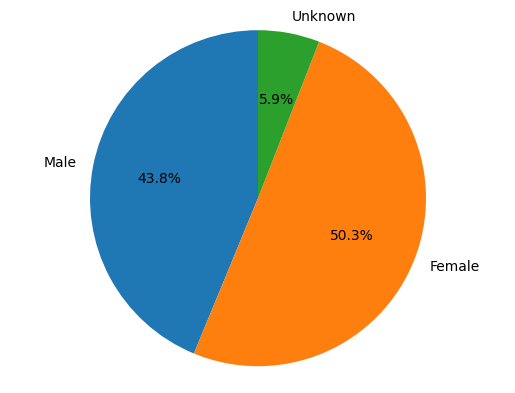

In [14]:
# count each gender
n_male = data[data['gender'] == 'm'].shape[0]
n_female = data[data['gender'] == 'f'].shape[0]
n_unknown = data[data['gender'] == 'u'].shape[0]

# print(f"{n_male=}, {n_female=}, {n_unknown=}")

# plot the distribution
labels = ['Male', 'Female', 'Unknown']
sizes = [n_male, n_female, n_unknown]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### Age distribution

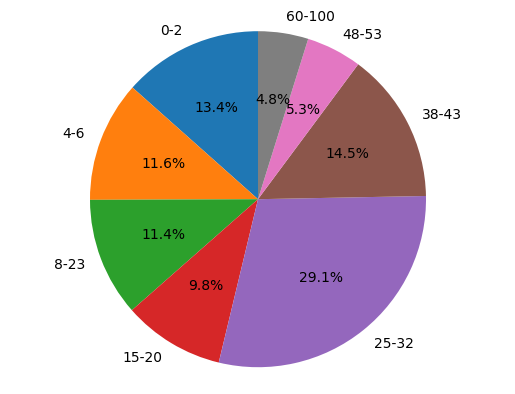

In [15]:
# count each age group
n_0_2 = data[data['age'] == '(0, 2)'].shape[0]
n_4_6 = data[data['age'] == '(4, 6)'].shape[0]
n_8_12 = data[data['age'] == '(8, 12)'].shape[0]
n_8_23 = data[data['age'] == '(8, 23)'].shape[0]
n_15_20 = data[data['age'] == '(15, 20)'].shape[0]
n_25_32 = data[data['age'] == '(25, 32)'].shape[0]
n_38_43 = data[data['age'] == '(38, 43)'].shape[0]
n_48_53 = data[data['age'] == '(48, 53)'].shape[0]
n_60_100 = data[data['age'] == '(60, 100)'].shape[0]

# plot the distribution
labels = ['0-2', '4-6', '8-23', '15-20', '25-32', '38-43', '48-53', '60-100']
sizes = [n_0_2, n_4_6, n_8_23, n_15_20, n_25_32, n_38_43, n_48_53, n_60_100]

fig2, ax2 = plt.subplots()
ax2.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### save the data to a csv file


In [16]:
update_train_df = pd.DataFrame(columns=data.columns)
update_test_df = pd.DataFrame(columns=data.columns)
train_rows = []
test_rows = []

for index, row in train_df.iterrows():
    # Take the row from the data
    data_row = data[(data['original_image'] == row['original_image']) & (data['face_id'] == row['face_id'])]
    # Append the data_row to the list
    train_rows.append(data_row)

# Convert the list of rows to a DataFrame
update_train_df = pd.concat(train_rows, ignore_index=True)

for index, row in test_df.iterrows():
    # Take the row from the data
    data_row = data[(data['original_image'] == row['original_image']) & (data['face_id'] == row['face_id'])]
    # Append the data_row to the list
    test_rows.append(data_row)

update_test_df = pd.concat(test_rows, ignore_index=True)
print(f"{update_train_df.shape=}")
print(f"{update_test_df.shape=}")

update_train_df.shape=(14820, 5)
update_test_df.shape=(3731, 5)


### check the intersection between the train and test sets
we want that the train and test sets will not have the same images

In [17]:
intersection_df = pd.merge(update_train_df, update_test_df, how='inner')

# Display the intersection DataFrame
print(intersection_df)

Empty DataFrame
Columns: [user_id, face_id, original_image, age, gender]
Index: []


### save the train and test sets to csv files
first we split the train set to train and validation sets
and then we save the train, validation, and test sets to csv files

In [18]:
# Split the train set to train and validation sets
train_df, val_df = train_test_split(update_train_df, test_size=0.2, random_state=42)

# Save the train, validation, and test sets to csv files
train_df.to_csv(os.path.join('data','train.csv'), index=False)
val_df.to_csv(os.path.join('data','val.csv'), index=False)
update_test_df.to_csv(os.path.join('data','test.csv'), index=False)